In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

In [2]:
uH = 1e-6
mH = 1e-3

pF = 1e-12
nF = 1e-9
uF = 1e-6

MHz = 1e6
kHz = 1e3

In [3]:
class Port():
    def z(self, f): return 1 / self.y(f)
    def y(self, f): return 1 / self.z(f)

class Component(Port):
    def __init__(self):
        self.val = None
    def apply(self, v, f):
        self.v = [cmath.polar(vv)[0] for vv in v]
        self.phase = [180*cmath.polar(vv)[1]/np.pi for vv in v]
        self.f = f
        
class Res(Component):
    def __init__(self, ohms):
        self.val = ohms
    def z(self, f):
        return self.val * np.ones_like(f)
    
class Coil(Component):
    def __init__(self, henries):
        self.val = henries
    def z(self, f):
        return 2 * np.pi * f * self.val * 1j
    
class Cap(Component):
    def __init__(self, farads):
        self.val = farads
    def y(self, f):
        return 2 * np.pi * f * self.val * 1j

class Series(Port):
    def __init__(self, *elems):
        self.elems = elems
    
    def z(self, f):
        return sum([port.z(f) for port in self.elems])
    
    def apply(self, v, f):
        zt = self.z(f)
        for ckt in self.elems:
            ckt.apply( v * (ckt.z(f) / zt), f)
        
class Parallel(Port):
    def __init__(self, *elems):
        self.elems = elems
    
    def y(self, f):
        return sum([port.y(f) for port in self.elems])
    
    def apply(self, v, f):
        for ckt in self.elems:
            ckt.apply(v, f)

In [4]:
# This be the impedance, purely reactive.
Cap(0.1 * uF).z(10 * MHz)

-0.15915494309189535j

In [5]:
# And this be the admittance, purely susceptant.
Cap(0.1 * uF).y(10 * MHz)

6.283185307179586j

In [6]:
def Tee(p1, p2, p3, load):
    return Series(p1, Parallel(p2, Series(p3, load)))

R50 = Res(50)

L1 = L3 = Coil(5.5 * uH)
L2 = Coil(2.6 * uH)
C7 = C9 = Cap(680 * pF)
C8 = Cap(1500 * pF)

bpf_1p8_4 = Tee(p1=Series(C7, L1), p2=Parallel(C8, L2), p3=Series(C9, L3), load=R50)

L4 = L6 = Coil(2.0 * uH)
L5 = Coil(0.46 * uH)
C11 = C13 = Cap(390 * pF)
C12 = Cap(1500 * pF)

bpf_4_8 = Tee(p1=Series(C11, L4), p2=Parallel(C12, L5), p3=Series(C13, L6), load=R50)

L7 = L9 = Coil(1 * uH)
L8 = Coil(0.27 * uH)
C14 = C16 = Cap(180 * pF)
C15 = Cap(680 * pF)

bpf_8_16 = Tee(p1=Series(C14, L7), p2=Parallel(C15, L8), p3=Series(C16, L9), load=R50)

L10 = L12 = Coil(0.46 * uH)
L11 = Coil(0.13 * uH)
C17 = C19 = Cap(100 * pF)
C18 = Cap(390 * pF)

bpf_16_30 = Tee(p1=Series(C17, L10), p2=Parallel(C18, L11), p3=Series(C19, L12), load=R50)

In [7]:
def fplot(filt, source, load, f_start=1*MHz, f_end=30*MHz, f_step=1*kHz):
    """Filter response plot for filter fed by source impedance.
    
    The load is contained within the filter, the source impedance is not.
    """

    freq = np.arange(f_start, f_end, f_step)

    ref_filt = Series(source, load)
    ref_filt.apply(1.0, freq)
    ref_resp = 20*np.log10(load.v)
    
    fed = Series(source, filt)
    
    fed.apply(1.0, freq)
    response = 20 * np.log10(load.v)
        
    fig, ax = plt.subplots()
    ax.plot(freq / MHz, response - ref_resp)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Loss (dB)')
    ax.grid(True)

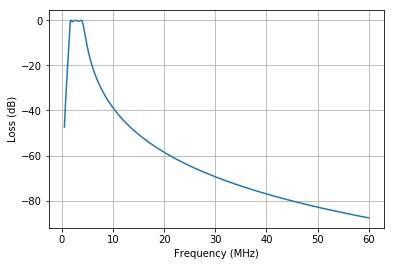

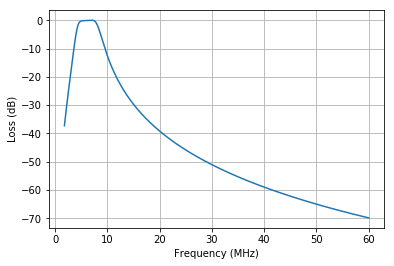

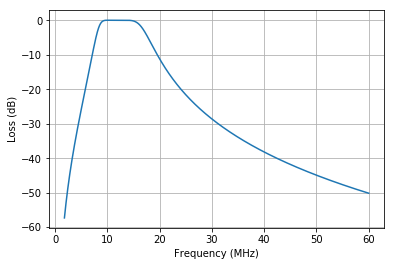

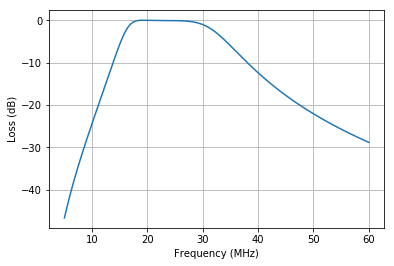

In [8]:
fplot(bpf_1p8_4, source=Res(50), load=R50, f_start=500*kHz, f_end=60*MHz)
fplot(bpf_4_8, source=Res(50), load=R50, f_start=1.8*MHz, f_end=60*MHz)
fplot(bpf_8_16, source=Res(50), load=R50, f_start=1.8*MHz, f_end=60*MHz)
fplot(bpf_16_30, source=Res(50), load=R50, f_start=5*MHz, f_end=60*MHz)

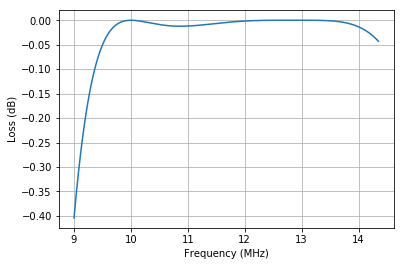

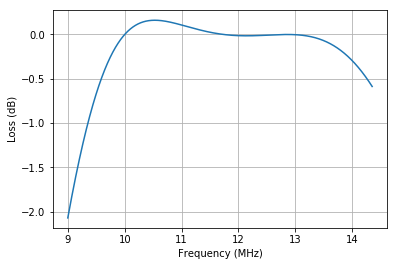

In [9]:
# The passband edge of bpf_8_16 is close to the 20 meter band.

# The actual filter shows only slight rolloff on 20 meters
# when fed with a perfectly-matched antenna or signal generator.

fplot(bpf_8_16, source=Res(50), load=R50, f_start=9.0*MHz, f_end=14.35*MHz)

# But the loss is more severe if fed with a high-impedance antenna,
# maybe a random wire.  We can try some reactive sources too--it might be different.
# Note also that this filter exhibits a transmatch-like gain at around 10 MHz,
# coupling the signal from the 300-ohm antenna to the load better than would
# happen by just connecting that antenna to the load directly.
fplot(bpf_8_16, source=Res(300), load=R50, f_start=9.0*MHz, f_end=14.35*MHz)


In [10]:
def fr(L, C):
    return 1 / (2 * np.pi * np.sqrt(L.val * C.val))

f1 = fr(L7, C14)
f2 = fr(L8, C15)
f3 = fr(L9, C16)

for f in [f1, f2, f3]:
    print(f'{f / kHz :,.0f} kHz')

print(f'{L7.z(f1) :,.2f} ohms')
print(f'{L8.z(f2) :,.2f} ohms')
print(f'{L9.z(f3) :,.2f} ohms')

11,863 kHz
11,746 kHz
11,863 kHz
0.00+74.54j ohms
0.00+19.93j ohms
0.00+74.54j ohms


In [11]:
def zplots(ckt, f_start=1*MHz, f_end=30*MHz, f_step=1*kHz):
    f = np.arange(f_start, f_end, f_step)
    z = ckt.z(f)
    
    fig, mag = plt.subplots()
    mag.semilogy(f / MHz, abs(z))
    mag.set_xlabel('Frequency (MHz)')
    mag.set_ylabel('Z Magnitude')
    mag.grid(True)
    
    fig, phase = plt.subplots()
    phase.plot(f / MHz, np.angle(z, deg=True))
    phase.set_xlabel('Frequency (MHz)')
    phase.set_ylabel('Z Degrees')
    phase.grid(True)
    
    fig, res = plt.subplots()
    res.plot(f / MHz, np.real(z))
    res.set_xlabel('Frequency (MHz)')
    res.set_ylabel('Z Real')
    res.grid(True)
  

In [12]:
def capacitor(freq, ohms):
    "Capacitor that has ohms reactance at freq"
    return Cap(1 / (2 * np.pi * freq * ohms))

def inductor(freq, ohms):
    "Inductor that has ohms reactance at afreq"
    return Coil(ohms / (2 * np.pi * freq))


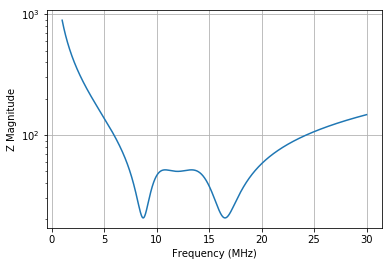

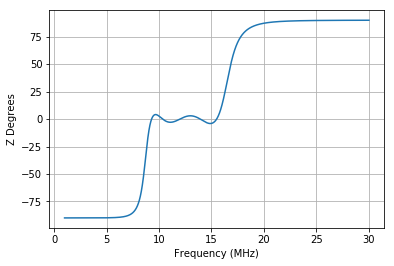

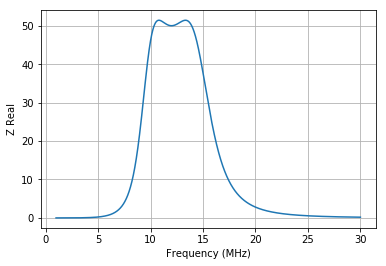

In [13]:
# Ideal filter with exact components for 8 to 16 MHz
R_out = Res(50)

C_12_75 = capacitor(12 * MHz, ohms=75)
L_12_75 = inductor(12 * MHz, ohms=75)

C_12_20 = capacitor(12 * MHz, ohms=20)
L_12_20 = inductor(12 * MHz, ohms=20)

bpf_8_16_ideal = Tee(p1=Series(C_12_75, L_12_75), 
                     p2=Parallel(C_12_20, L_12_20),
                     p3=Series(C_12_75, L_12_75),
                     load=Res(50))

zplots(bpf_8_16_ideal)

In [14]:
# Component values for this ideal filter.
print(C_12_75.val / pF, "pF")
print(L_12_75.val / uH, "uH")
print("")
print(C_12_20.val / pF, "pF")
print(L_12_20.val / uH, "uH")

176.83882565766146 pF
0.994718394324346 uH

663.1455962162306 pF
0.26525823848649227 uH


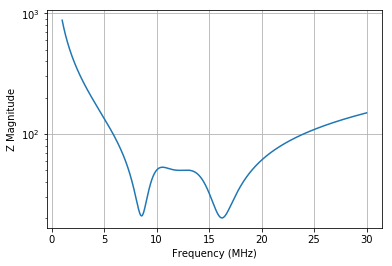

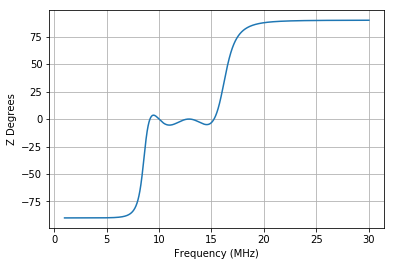

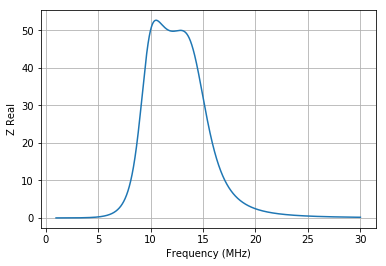

In [15]:
zplots(bpf_8_16)

In [16]:
def Pi(p1, p2, p3, load):
    return Parallel(p1, Series(p2, Parallel(p3, load)))

def Attenuator(load):
    return Pi(p1=Res(75), p2=Res(120), p3=Res(75), load=load)


In [17]:
# 8640B filters

# 8-16 MHz Low Band
C24 = Cap(360 * pF)
L10 = Coil(0.924 * uH)
C25 = Cap(640 * pF)
L11 = Coil(1.0 * uH)
C26 = Cap(640 * pF)
L12 = Coil(0.924 * uH)
C27 = Cap(390 * pF)

for component in [C24, L10, C25, L11, C26, L12, C27]:
    print(component.z( (8 + 11.313)/2 * MHz))


-45.782329430347815j
56.06238692095243j
-25.752560304570647j
60.67357891877968j
-25.752560304570647j
56.06238692095243j
-42.260611781859524j


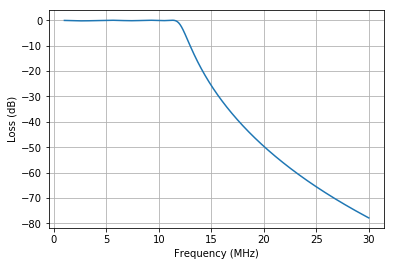

In [18]:
def Pi_3_Section(p1, p2, p3, p4, p5, p6, p7, load):
    return Parallel(p1, Series(p2, Parallel(p3, Series(p4, Parallel(p5, Series(p6, Parallel(p7, load)))))))


LPF_8_16_LO = Pi_3_Section(C24, L10, C25, L11, C26, L12, C27, load=R50)
fplot(LPF_8_16_LO, source=Res(50), load=R50)

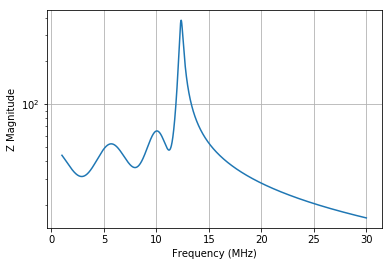

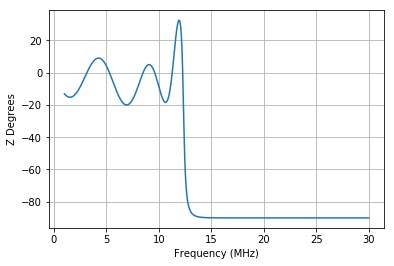

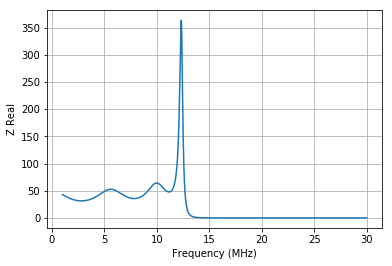

In [19]:
zplots(LPF_8_16_LO)

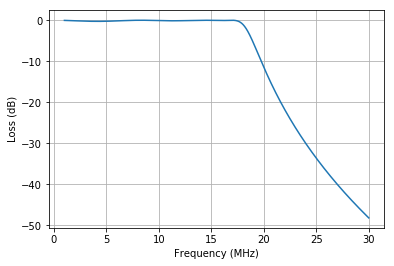

In [20]:
# 8-16 MHz High Band

C28 = Cap(240 * pF)
L13 = Coil(0.600 * uH)
C29 = Cap(430 * pF)
L14 = Coil(0.646 * uH)
C30 = Cap(430 * pF)
L15 = Coil(0.600 * uH)
C31 = Cap(240 * pF)

LPF_8_16_HI = Pi_3_Section(C28, L13, C29, L14, C30, L15, C31, load=R50)

fplot(LPF_8_16_HI, source=Res(50), load=R50)


In [26]:
# Robert's filter.

R1 = Res(200_000)
R2 = Res(1000)
Rload = Res(5000)
C1 = Cap(80 * nF)
C2 = Cap(40 * nF)

ac7ke = Series(R1, Parallel(C1, R2, Series(C2, Rload)))


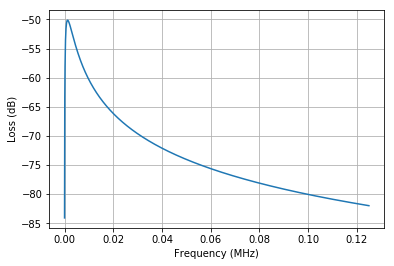

In [32]:
fplot(ac7ke, source=Res(0), load=Rload, f_start=10, f_end = 125_000, f_step=100)

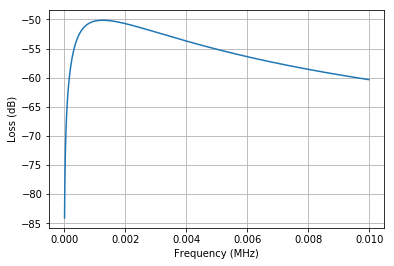

In [33]:
fplot(ac7ke, source=Res(0), load=Rload, f_start=10, f_end = 10_000, f_step=10)

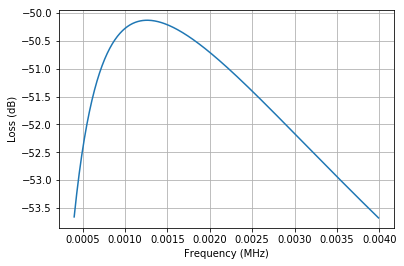

In [34]:
fplot(ac7ke, source=Res(0), load=Rload, f_start=400, f_end = 4000, f_step=10)